![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Advanced RNN - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainAdvancedRNN_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

### Exercise:
* Use the advanced units and get above 85% accuracy on the sentiment analysis task.  
* (Keep all sequences with less than 150 words.)

In [5]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

In [6]:
def NumWords(line):
    return len(line.split())

maxLength = 150
lTrainSet = [(label, line) for (label, line) in trainIter if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in testIter  if NumWords(line) < maxLength]

In [7]:
len(trainIter), len(testIter), len(lTrainSet), len(lTestSet)

(25000, 25000, 9746, 9932)

In [8]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenized:---------------------------')    
    print(oTokenizer(line))

Yet another example of what British cinema can achieve: a simple story, told and acted well. Brenda Blethyn gives a layered and warming performance as the recently widowed and financially straitened Grace, ably assisted by a solid supporting cast. The "quirky small town" card gets played to the hilt, similar to many TV series and films that have come from the British Isles in recent years (Ballykissangel, Hamish Macbeth and others come to mind). Like the forementioned, this film makes use of some ravishingly beautiful rural scenery, in this case the wet and wild Cornish coast.<br /><br />Some viewers might find wholesale acceptance of cannabis use a bit challenging, others might find the ending just a little too cute and safe. But it's an enjoyable spliff, to be sure.
--Tokenized:---------------------------
['yet', 'another', 'example', 'of', 'what', 'british', 'cinema', 'can', 'achieve', 'a', 'simple', 'story', ',', 'told', 'and', 'acted', 'well', '.', 'brenda', 'blethyn', 'gives', 'a

In [9]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lDataset):
    for (label, line) in lDataset:
        yield oTokenizer(line)

oVocab = build_vocab_from_iterator(YieldTokens(lTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

10450

In [10]:
def Text2Tensor(line):
    lLine = ['<SOS>'] + [token for token in oTokenizer(line)] + ['<EOS>']
    return torch.tensor(oVocab(lLine))

def Label2Int(label):
    if label == 'pos':
        return 1
    else:
        return 0

# Print out the output of text_transform
line = 'Hello World!'
print('Input :', line)
print('Output:', Text2Tensor(line))

Input : Hello World!
Output: tensor([   1, 3630,  212,   25,    2])


In [11]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def CollateBatch(lBatch):
    Nb  = len(lBatch)
    vY  = torch.empty(Nb)
    lX  = [None] * Nb
    for ii, (label, line) in enumerate(lBatch):
        vY[ii] = Label2Int  (label)
        lX[ii] = Text2Tensor(line)
    
    mPackX = pack_sequence(lX, enforce_sorted=False)

    return mPackX, vY

In [12]:
batchSize = 128
oTrainDL  = DataLoader(lTrainSet, batch_size=1*batchSize, shuffle=True, collate_fn=CollateBatch)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=True, collate_fn=CollateBatch)

In [13]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

V = len(oVocab)
D = 24
H = 16
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.oEmbedding = nn.Embedding(V,   D, padding_idx=oVocab['<pad>'])
        self.oGRU       = nn.GRU      (D,   H, num_layers=1, bidirectional=True)
        self.oFC        = nn.Linear   (2*H, 1)
        
    def forward(self, mPackX):
                                                             #-- mPackX.shape = (N*T,)
        mE     = self.oEmbedding(mPackX.data)                #-- mE    .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackX)                 #-- mPackE.shape = (N*T, D)
        _, mH  = self.oGRU      (mPackE)                     #-- mH    .shape = (2,   N, H)
        mH     = torch.cat([mH[-1,:,:], mH[-2,:,:]], dim=1)  #-- mH    .shape = (N,   2*H)
        mZ     = self.oFC       (mH)                         #-- mZ    .shape = (N,   1)
        return mZ[:,0]

In [14]:
mPackX, vY = next(iter(oTrainDL))
RNN()(mPackX).shape

torch.Size([128])

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [16]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainModel

nEpochs       = 50
nIter         = nEpochs * len(oTrainDL)

oModel        = RNN        ().to(DEVICE)
oOptim        = optim.AdamW(oModel.parameters(), lr=2e-5, betas=(0.8, 0.9), weight_decay=5)
oScheduler    = OneCycleLR (oOptim, max_lr=2e-3, total_steps=nIter)
lHistory      = TrainModel (oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler);

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.694 | Val loss:  0.694 | Train Metric:  0.498 | Val Metric:  0.505 | epoch time:  3.866 | <-- Checkpoint!
Epoch 001: | Train loss:  0.693 | Val loss:  0.692 | Train Metric:  0.506 | Val Metric:  0.522 | epoch time:  3.441 | <-- Checkpoint!
Epoch 002: | Train loss:  0.691 | Val loss:  0.691 | Train Metric:  0.523 | Val Metric:  0.541 | epoch time:  3.336 | <-- Checkpoint!
Epoch 003: | Train loss:  0.690 | Val loss:  0.690 | Train Metric:  0.543 | Val Metric:  0.547 | epoch time:  3.290 | <-- Checkpoint!
Epoch 004: | Train loss:  0.689 | Val loss:  0.689 | Train Metric:  0.553 | Val Metric:  0.555 | epoch time:  3.278 | <-- Checkpoint!
Epoch 005: | Train loss:  0.688 | Val loss:  0.688 | Train Metric:  0.561 | Val Metric:  0.543 | epoch time:  3.240 |
Epoch 006: | Train loss:  0.685 | Val loss:  0.685 | Train Metric:  0.579 | Val Metric:  0.

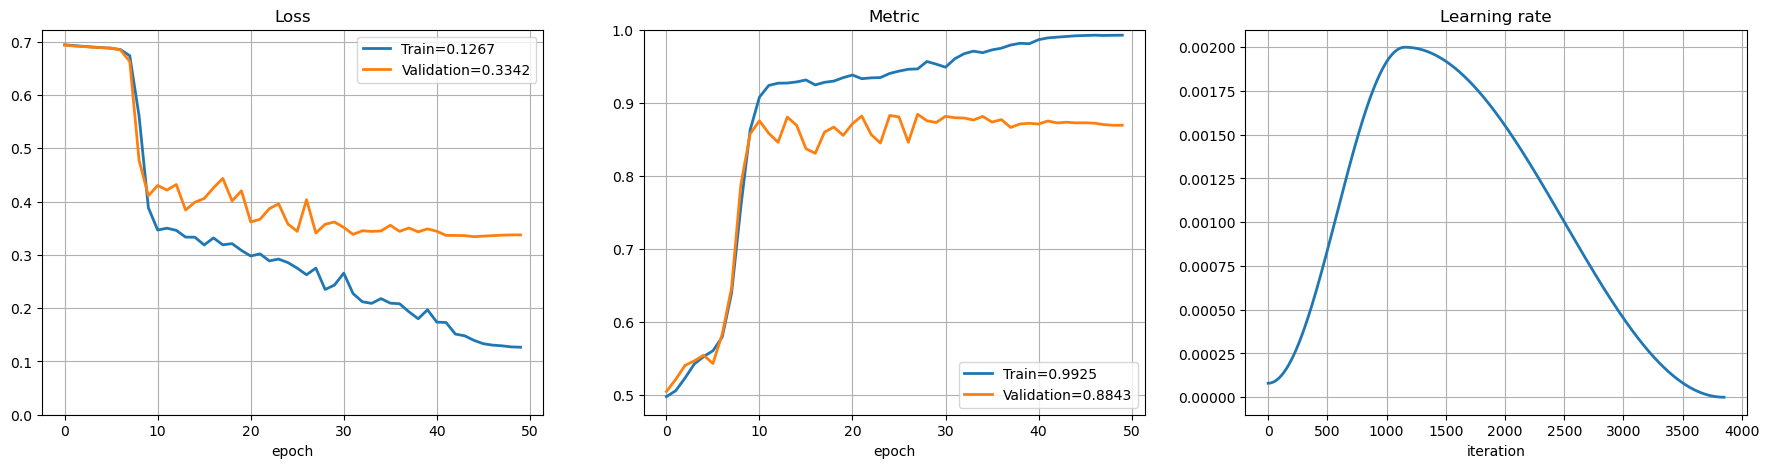

In [17]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()